I had a meeting with Risa the other day and she suggested some of the problem's I've been having were coming from the simulations and not my code. To avoid being distracted, she suggested I basically mock up some results and pull them out. I'm expecting this to be easy because my modeling framework is debugged and coded up. 

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [7]:
from astropy.io import fits
#dataDir = '/home/sean/Data/BuzzardSims/'
dataDir = '/nfs/slac/g/ki/ki19/des/erykoff/clusters/mocks/Buzzard/buzzard-1.1/des_y5/redmapper_v6.4.7/halos/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_00340_lambda_chisq.fit')
data = hdulist[1].data

import numpy as np
mass = data['M200']
print 'Rows:\t%d'%mass.shape[0]
redshifts = data['Z']

mass = mass[redshifts<0.9]#Take only the first bin
redshifts = redshifts[redshifts<0.9]

logMass = np.log10(mass)

Rows:	76997


The model in the paper Risa sent me is:

$ \log{\lambda}(M) = \log{\lambda_0} + A_{\lambda}\log{\frac{M}{M_{piv}}}+B_{\lambda} \log{\frac{1+z}{1.3}} $

Where $A_{\lambda}$ is allowed to vary with redshift by:

$ A_{\lambda} \equiv a \left(\frac{1+z}{1.3} \right)^b $

The defined/measured values for these params are shown in the table below (with uncertainties surpressed). I will use these to draw a richness sample and then infer them back. 

| Quantity | Value |
|:--- | ----------------------------------------: |
| $M_{piv}$ | $2.35 \times 10^{14} \; M_{\odot} $ | 
| $\log{\lambda_0}$ | 3.141 | 
| $a$ | 0.842 |
| $b$ | -0.03 |
| $ B_{\lambda} $ | 0.642 |
| $ \sigma_{\lambda} $ | 0.184 | 

In [8]:
M_piv = 2.35e14
logLam0 = 3.141
a, b = 0.842, -0.03
B_lam = 0.642
sigma_lam = 0.184

def _A_lam(a, b, z):
    return a*pow((1+z)/1.3, b)
from scipy.stats import norm
#forward model
def logLam(logLam0, a, b, B_lam, z, M):
    A_lam = _A_lam(a,b,z)
    return logLam0+A_lam*np.log(M/M_piv)+B_lam*np.log((1+z)/1.3)

def logLamSample(logLam0, a, b, B_lam,sigma_lam, z,M):
    return norm.rvs(loc = logLam(logLam0, a, b, B_lam, z, M), scale = sigma_lam)

In [9]:
logRichness = logLamSample(logLam0, a, b, B_lam, sigma_lam, redshifts, mass)

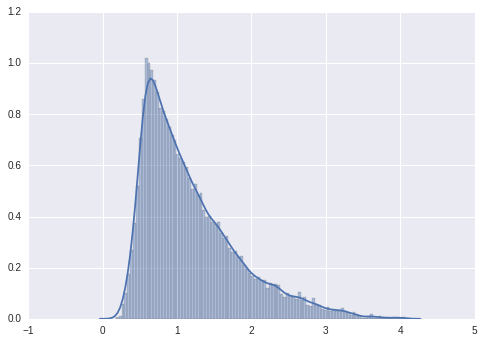

In [10]:
sns.distplot(logRichness, bins = 100)

/u/ki/swmclau2/PYENV/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


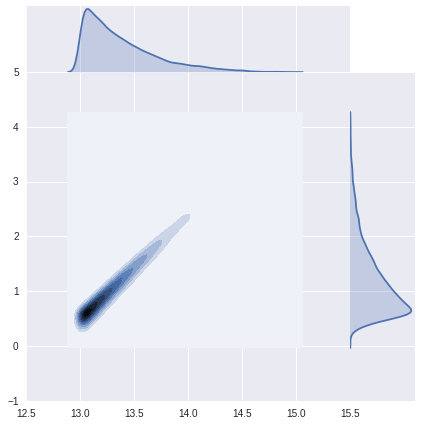

In [11]:
sns.jointplot(logMass, logRichness, kind = 'kde', stat_func = None, space = 0)

I haven't decided if I will go for inferring the full model off the bat or cheat a little bit first. I'll plot up a PGM of the full model first for refence. 

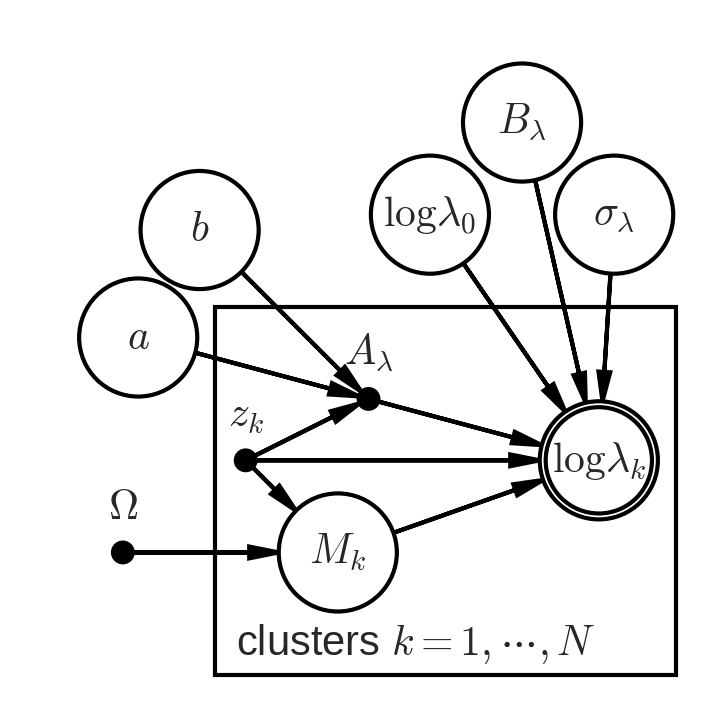

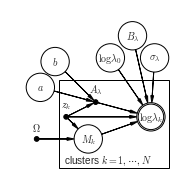

In [12]:
import daft

pgm = daft.PGM([2.3, 2.3], origin=[.3,.3], grid_unit = 2.6, node_unit=1, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,.8,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma_{\lambda}$", 2.3, 1.9))
pgm.add_node(daft.Node("B_l", r"$B_{\lambda}$", 2, 2.2))
pgm.add_node(daft.Node("logL", r"$\log{\lambda_0}$", 1.7, 1.9))

pgm.add_node(daft.Node("a", r"$a$", .75, 1.5))
pgm.add_node(daft.Node("b", r"$b$", .95, 1.85))

pgm.add_node(daft.Node("redshift", r"$z_k$", 1.1,1.1,fixed =True))

pgm.add_node(daft.Node("A_l", r"$A_{\lambda}$", 1.5, 1.3, fixed = True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.4,.8))

pgm.add_node(daft.Node("logRichness", r"$\log{\lambda_k}$", 2.25,1.1,observed=True))

pgm.add_edge("a", "A_l")
pgm.add_edge("b", "A_l")

pgm.add_edge("B_l", "logRichness")
pgm.add_edge("logL", "logRichness")
pgm.add_edge("A_l", "logRichness")
pgm.add_edge("scatter", "logRichness")
pgm.add_edge("Mcluster", "logRichness")

pgm.add_edge("redshift", "Mcluster")
pgm.add_edge("redshift", "A_l")
pgm.add_edge("redshift", "logRichness")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([1,.5,1.5,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render();
pgm.figure.savefig("newModelPGM.png", dpi = 300)
from IPython.display import Image
Image("newModelPGM.png")

This is considerably more complex than what I was doing before; all of that is coming from the redshift dependance of richness. Doubt that was Risa's intent but no matter! Shouldn't mess things up too badly.For sanity purposes I'll work with a very slightly simlified version for now:

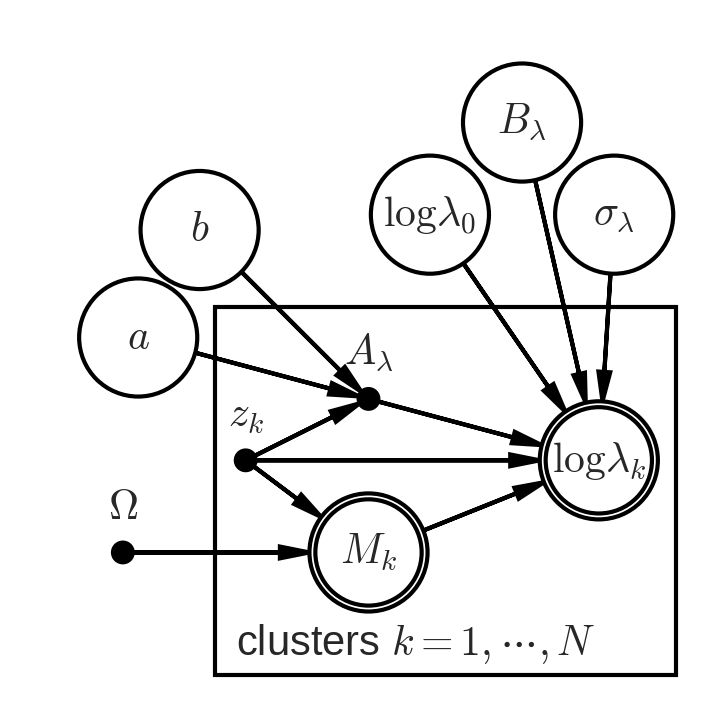

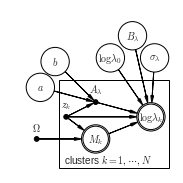

In [13]:
import daft

pgm = daft.PGM([2.3, 2.3], origin=[.3,.3], grid_unit = 2.6, node_unit=1, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,.8,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma_{\lambda}$", 2.3, 1.9))
pgm.add_node(daft.Node("B_l", r"$B_{\lambda}$", 2, 2.2))
pgm.add_node(daft.Node("logL", r"$\log{\lambda_0}$", 1.7, 1.9))

pgm.add_node(daft.Node("a", r"$a$", .75, 1.5))
pgm.add_node(daft.Node("b", r"$b$", .95, 1.85))

pgm.add_node(daft.Node("redshift", r"$z_k$", 1.1,1.1,fixed =True))

pgm.add_node(daft.Node("A_l", r"$A_{\lambda}$", 1.5, 1.3, fixed = True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.5,.8, observed = True))

pgm.add_node(daft.Node("logRichness", r"$\log{\lambda_k}$", 2.25,1.1,observed=True))

pgm.add_edge("a", "A_l")
pgm.add_edge("b", "A_l")

pgm.add_edge("B_l", "logRichness")
pgm.add_edge("logL", "logRichness")
pgm.add_edge("A_l", "logRichness")
pgm.add_edge("scatter", "logRichness")
pgm.add_edge("Mcluster", "logRichness")

pgm.add_edge("redshift", "Mcluster")
pgm.add_edge("redshift", "A_l")
pgm.add_edge("redshift", "logRichness")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([1,.5,1.5,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render();
pgm.figure.savefig("newModelPGM2.png", dpi = 300)
from IPython.display import Image
Image("newModelPGM2.png")

Difference is subtle, but now there's no integral. This reduces the sampler's dimension by a lot. 

In [14]:
#First, will need the parameters
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0e14, 1.0e14]#*10^14
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

#interpolates naively between the points given in the original paper
z_params = {}
from scipy.stats import linregress
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)

#return the values of the parameters at a given z. 
def getMassParams(z):
    return {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

def n_approx(m,z):
    params = getMassParams(z)
    return params['A']*np.exp(-params['B1']*(m/params['Mp']) \
                    -0.5*params['B2']*(m/params['Mp'])**2 \
                    -0.166*params['B3']*(m/params['Mp'])**3)

def log_n_approx(m,z):
    params = getMassParams(z)
    return -1*(params['B1']*(m/params['Mp']) \
                    +0.5*params['B2']*(m/params['Mp'])**2 \
                    +0.166*params['B3']*(m/params['Mp'])**3)+np.log(params['A'])

In [15]:
from scipy.stats import gamma, lognorm, expon
def log_prior(a,b, logL0,B_l, sigma):
    
    if any(x<0 for x in (logL0,sigma)):
        return -np.inf

    t1 = np.arctan(B_l)
    t2 = np.arctan(a)
    #if t<0 or t>np.pi/2:
    if any(x< -np.pi/2 or x> np.pi/2 for x in (a,B_l)):
        return -np.inf
    
    #Hyperparameters
    lambda_logL0 = 1.0
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in logL0
    p+= expon.logpdf(logL0, scale = 1/lambda_logL0)
    #Uniform in arctan(B_l) and arctan(a)
    p+=2*np.log(2/np.pi)
    #flat prior for b
    #Have not idea what it would be, start with nothing
    #p+=0
    
    #Inv Gamma for sigma
    #TODO should be sigma^2?
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    return p

p_mass = np.sum(log_n_approx(mass,redshifts))

def log_liklihood(logRich, a,b,logL0, B_l, sigma,z, M):
    p = 0
    #p+= np.sum(log_n_approx(M,z))#not normalized, if that's a problem i can approximate it. 
    p+=p_mass #It's a constant, save some time. 
    #a => logA
    #log Normal liklihood
    #p+= np.sum(lognorm.logpdf(rich, sigma, loc = (b*(np.log(M)-offset)+np.log(a))))
    p+=np.sum(norm.logpdf(logRich, loc =logLam(logLam0, a, b, B_l, z, M), scale = sigma))
    return p

def log_posterior(theta,logRich, M,z):
    #print theta
    a,b,logL0, B_l, sigma = theta[:]
    p = log_prior(a,b, logL0, B_l, sigma)
    if np.isfinite(p):
        p+=log_liklihood(logRich,a,b,logL0, B_l, sigma,z,M)
    return p

In [16]:
ndim = 5
nwalkers = 1000

a_mean, a_spread = 1, 1.5
b_mean, b_spread = 0, .5
logL0_a, logL0_b = 1, 1
B_l_mean, B_l_spread = 1, 1.5
sigma_a, sigma_b = 1, 1

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:

    row[0] = norm.rvs(loc = a_mean, scale = a_spread)
    row[1] = norm.rvs(loc = b_mean, scale = b_spread)
    row[2] = gamma.rvs(logL0_a, scale = logL0_b)
    row[3] = norm.rvs(loc = B_l_mean, scale = B_l_mean)
    row[4] = gamma.rvs(sigma_a, scale = sigma_b)

In [17]:
import emcee as mc
import multiprocessing
#nCores = multiprocessing.cpu_count()
nCores = 4
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[logRichness, mass, redshifts],threads = nCores)
nsteps, nburn = 600, 100

In [18]:
print '-*'*25
print 'Num Dim:\t%d\nNum Walkers:\t%d\nNum Steps:\t%d\nNum Burn:\t%d'%(ndim, nwalkers, nsteps, nburn)
print '-*'*25

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Num Dim:	5
Num Walkers:	1000
Num Steps:	600
Num Burn:	100
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [19]:
np.random.seed(0)#"random"

sampler.run_mcmc(pos0, nsteps);

In [20]:
chain = sampler.chain[:,nburn:, :].reshape((-1, ndim))
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain.mean(axis = 0)
labels = ['a', 'b','logL0','B_l','sigma']
print '\tMCMC\tTrue'
for label, val, truth in zip(labels, MAP, [a, b, logLam0, B_lam, sigma_lam]):
    print '%s:\t%.3f\t%.3f'%(label, val, truth)

	MCMC	True
a:	1.233	0.842
b:	-0.259	-0.030
logL0:	1.222	3.141
B_l:	0.218	0.642
sigma:	0.190	0.184


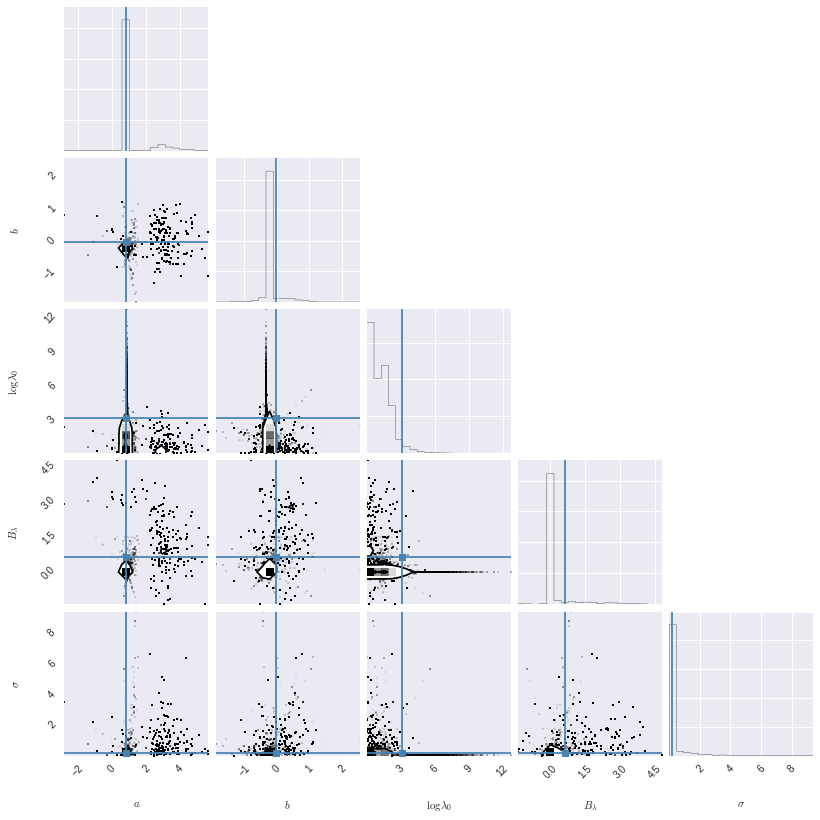

In [21]:
from corner import corner
titles = ['$a$', '$b$','$\log{\lambda_0}$', '$B_{\lambda}$', '$\sigma$']
corner(chain, labels = titles , truths = [a, b,logLam0, B_lam, sigma_lam]);